# Fraud Detection

Fraud is an important problem that impacts the whole economy.</br>
Currently, there is a lack of public research into the detection of fraud. One important reason is the lack of transaction data which is often sensitive. To address this problem the database owner used a mobile money Payment Simulator (PaySim) and Retail Store Simulator (RetSim), which allow us to generate synthetic transactional data that contains both: normal customer behavior and fraudulent behavior. </br>

PaySim simulates mobile money transactions based on a sample of real transactions extracted from the logs of a mobile money service implemented in an African country. With the help of statistic analysis and social network analysis PaySim is able to generate congruous results with the original data set

## The Dataset:

The source of the data set is from Kaggle

The data set includes data about online transactions, some of them detected as fraud. every transaction contains:</br>

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
*   type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
    * CASH-IN is the process of increasing the balance of account by paying in cash to a merchant
    * CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account.
    * DEBIT is a similar process to CASH-OUT and involves sending the money from the mobile money service to a bank account
    * PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
    * TRANSFER is the process of sending money to another user of the service through the mobile money platform.
*   amount - amount of the transaction in local currency.
*   nameOrig - customer who started the transaction.
*   oldbalanceOrg - initial balance before the transaction
*   newbalanceOrig - new balance after the transaction.
*   nameDest - customer who is the recipient of the transaction
*   oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
*   newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
*   isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
*   isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



### Project Goal:

The goal of the project is to predict the fraudulent transactions

### Packages:

In [1]:
#Basic libraries:
import numpy as np
import pandas as pd

# For preprocessing:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Visualization libraries:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#for validating
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error as mse, auc

#for modeling
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from collections import Counter
import collections
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from lightgbm.sklearn import LGBMClassifier

# For the tree visualization
from IPython.display import Image
from io import StringIO

#for scoring
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import log_loss,recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

#neural_network
from sklearn.neural_network import MLPClassifier

# For imbalance data:
from imblearn.under_sampling import RandomUnderSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Helper functions

In [2]:
#plotting
def plot_bars_Fraud(df, title):
    ax = df.plot.bar(figsize=(7,5), rot=0, title=title, color=['#0A4F70', '#FF0021'])
    plt.title(title, fontsize=14, fontweight='bold')
    for p in ax.patches:
        ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
        ax.grid(True, axis='y',zorder=0)
        ax.set_axisbelow(True)

def plot_importance( features, coef , model_name):
    df = pd.DataFrame( zip(features,coef), columns = ['Features','coef'])
    if model_name == 'Logistic Regression':
        df['Importance'] = np.abs(df['coef']).round(2)
    else:
        df['Importance'] = df['coef']
    df.sort_values(by = 'Importance', ascending=False, inplace=True, ignore_index=True)

    num_feat = len(df)
    max_importance = df['Importance'][0]
    min_importance = df['Importance'][num_feat-1]



    plt.figure(figsize=(8,num_feat*0.2))
    ax = sns.barplot( data = df, x='Importance', y='Features', orient='h', palette='vlag_r')
    plt.title(f'{model_name}: Feature Importance')
    for i in ax.containers:
        ax.bar_label(i)

    plt.xlim(min(0,min_importance )*1.2,max_importance*1.2)
    plt.show()

    return df


def plot_NotFraud_vs_Fraud(colum_name):
    dflux = data[data['isFraud'] == 0][colum_name]
    dflux2 = data[data['isFraud'] == 1][colum_name]

    fig, axes = plt.subplots(1, 2)

    dflux.hist( bins=100, ax=axes[0], color ="skyblue", figsize=(10,3))
    dflux2.hist( bins=100, ax=axes[1], color ="red", figsize=(10,3))



def plot_roc_auc(ax, model, X_test, y_test, label,coloroc='red'):
    #ROC-AUC
    #predict Probabilities
    y_score_model = model.predict_proba(X_test) # results are probabilities for each sample for each class
    yes_probs = y_score_model[:,1] # retrieve the probabilities only for the class1 (yes, positve class)
    # calculate the features of ROC curve
    fpr_model, tpr_model, _ = roc_curve(y_test, yes_probs) # false positive, true posistive, threshold
    # AUC
    auc_model = auc(fpr_model, tpr_model)
    # Plot the ROC Curve
    label = f'{label} (auc={auc_model:.3f})'
    ax.plot(fpr_model, tpr_model, marker='_', label=label, color=coloroc)
    # X-axis label
    ax.set_xlabel("False Positive Rate")
    # Y-axis label
    ax.set_ylabel("True Positive Rate")
    # show the legend
    ax.legend()



#Validating
def class_conf_print(X, y, model ):
    cm = confusion_matrix(y_true=y,
                      y_pred=model.predict(X))
    report = classification_report(y_true=y,
                                y_pred=model.predict(X))

    print('-'*30,'Classification Report','-'*30)
    print(report[: report.index('macro avg')])

    print('-'*30,'Confusion Matrix','-'*30)
    disp = ConfusionMatrixDisplay(cm, display_labels=['No','Yes'])
    fig, ax = plt.subplots(figsize=(3,3))
    disp.plot(ax=ax, cmap='cividis', values_format=",d")
    plt.show()



# Model results
def model_results(X_train,y_train ,X_test, y_test, model):
    print('-'*40,'Train','-'*40)
    class_conf_print(X_train,y_train, model)

    print('-'*40,'Test','-'*40)
    class_conf_print(X_test, y_test, model)

    print(f'logloss score: {log_loss(y_test, model.predict_proba(X_test)).round(3)}')
    y = np.where(y_test == 0, 'No','Yes')
    scores = model.predict_proba(X_test)[:, 1]
    print(f'AUC = {roc_auc_score(y=="Yes", scores).round(3)}')
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, _ = roc_curve(y, scores, pos_label='Yes')

    plt.plot(fpr, tpr, '-o',label='roc_auc (area = %0.2f)' % roc_auc)
    plt.title('ROC')
    plt.xlabel('FPR (False Positive Rate = 1-specificity)')
    plt.ylabel('TPR (True Positive Rate = sensitivity)')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()


def recall_precision_params(X, y, model,best=True, print_output = True ):
    if best:
        print(f'Best params: {model.best_params_}')
    recall = recall_score(y, model.predict(X)).round(3)
    precision = precision_score(y, model.predict(X)).round(3)
    if print_output:
        print(f'recall_score: {recall}')
        print(f'precision_score: {precision}')
    return recall,precision




### class for remove outliers:

In [3]:
class Sigma_Range():
  def __init__(self, sigma = 6, min_uni = 10):
    self.sigma = sigma
    self.min_uni = min_uni

  def fit(self, X):
    return X

  def transform(self, X):
    for col in X.columns:
      if X[col].nunique() > self.min_uni:
        X = X[(X[col] > (X[col].mean() - X[col].std()*self.sigma )) &
              (X[col] < (X[col].mean() + X[col].std()*self.sigma ))]
    return X

  def fit_transform(self, X):
    return self.transform(X)

## Get Data:

In [4]:
data = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

First of all, let's see more details about the dataset:

In [5]:
data.shape

(6362620, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
data.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [8]:
data.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

Check duplicated values:

In [9]:
data.duplicated().sum()

0

Check null values:

In [10]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

So from the first checks we can conclude:
1. There is one table with 11 features and 6,362,620 transactions
2. There are 3 categorical features- (type - object, isFraud (the target) - int, and isFlaggedFraoud - int).
3. There are no null or duplicated values.

## EDA - Exploring Data Analysis

### isFraud:

In [11]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

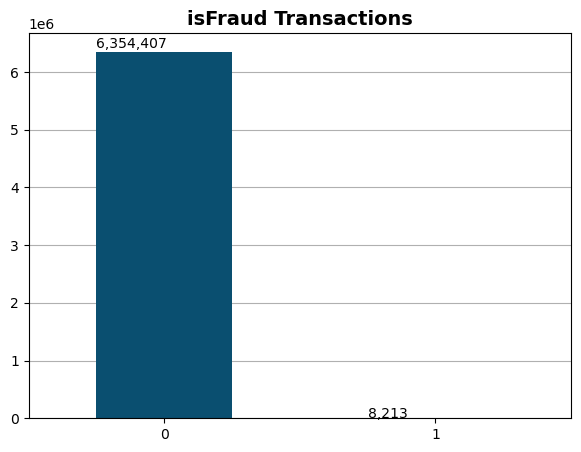

In [12]:
plot_bars_Fraud(data['isFraud'].value_counts(),"isFraud Transactions")

In [13]:
print(f"It's clear to see that we have imbalanced data. here're only {round((data['isFraud'].value_counts()[1]/data['isFraud'].value_counts().sum())*100,2)}% fraudulent transactions of all transactions.")

It's clear to see that we have imbalanced data. here're only 0.13% fraudulent transactions of all transactions.


### isFlaggedFraud:

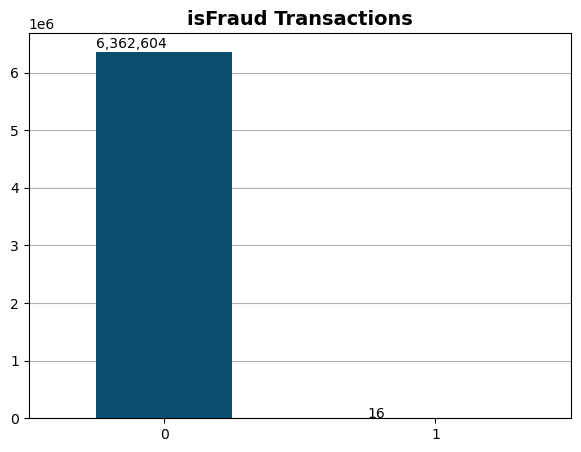

In [14]:
plot_bars_Fraud(data['isFlaggedFraud'].value_counts(),"isFraud Transactions")

There are only 16 transactions that the system flagged as fraud. Let's see if all of them were actual fraud:

In [15]:
data[data['isFlaggedFraud']==1].isFraud.value_counts()

1    16
Name: isFraud, dtype: int64

In [16]:
data[data['isFlaggedFraud']==1].type.value_counts()

TRANSFER    16
Name: type, dtype: int64

As seen above system was right with the transactions that flagged as fraud and all of them are transfer transactions.

In [17]:
data[(data['amount'] >= 200000) & (data['type'] == 'TRANSFER')]['isFlaggedFraud'].value_counts()

0    409094
1        16
Name: isFlaggedFraud, dtype: int64

In contrast to the data description there are transfer transactions of more than 200,000 that have not been flagged as fraud

### type:

In [18]:
data["type"].value_counts().sort_values(ascending=False)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [19]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(data, values=quantity, names=transactions,width=500,height=500, title="Distribution of Transaction Type",
                color_discrete_sequence=px.colors.sequential.RdBu)
figure.show()

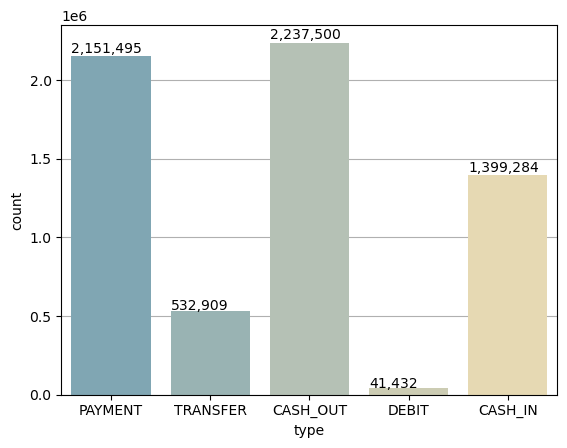

In [20]:
ax = sns.countplot(x='type', data=data, palette="blend:#7AB,#EDA")
for p in ax.patches:
  ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
  ax.grid(True, axis='y',zorder=0)
  ax.set_axisbelow(True)

As seen above:
* The most of the transactions are cash out and payment types.
* The least of the transactions are debit type.

Let's see which types include fraudulent transactions:

In [21]:
CrosstabResult_isFraud=pd.crosstab(index=data.type,columns=data.isFraud)
CrosstabResult_isFraud

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


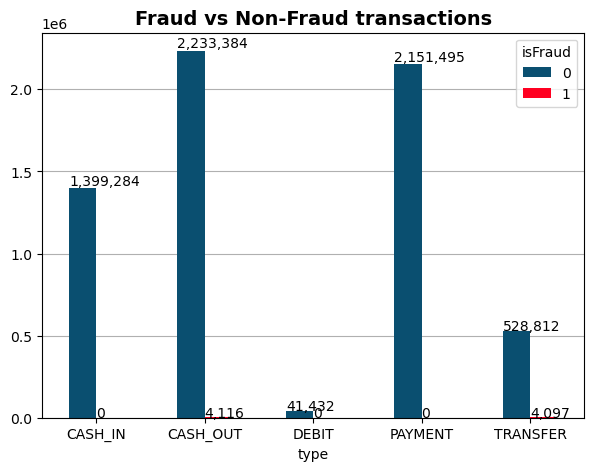

In [22]:
plot_bars_Fraud(CrosstabResult_isFraud, "Fraud vs Non-Fraud transactions")

* It's clear to see that only cash out and transfer types include fraudulent transactions

In [23]:
data.groupby('type').agg({'amount': ['mean', 'min', 'max']})

amount                   
                   mean   min          max
type                                      
CASH_IN   168920.242004  0.04   1915267.90
CASH_OUT  176273.964346  0.00  10000000.00
DEBIT       5483.665314  0.55    569077.51
PAYMENT    13057.604660  0.02    238637.98
TRANSFER  910647.009645  2.60  92445516.64

### sender & receiver:

In [24]:
data['sender_receiver_path'] = data['nameOrig'].str[:1]+data['nameDest'].str[:1]

In [25]:
data['sender_receiver_path'].value_counts()

CC    4211125
CM    2151495
Name: sender_receiver_path, dtype: int64

* So we can see that all the senders are customers. And the receivers are customers and merchants

let's check customers and merchants (receivers) by type:

In [26]:
pd.crosstab(index=data.type,columns=data.sender_receiver_path)


sender_receiver_path,CC,CM
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,0
DEBIT,41432,0
PAYMENT,0,2151495
TRANSFER,532909,0


We can see that all the merchants occurred only in payment type

In [27]:
pd.crosstab(index=data.sender_receiver_path,columns=data.isFraud)

isFraud,0,1
sender_receiver_path,,
CC,4202912,8213
CM,2151495,0


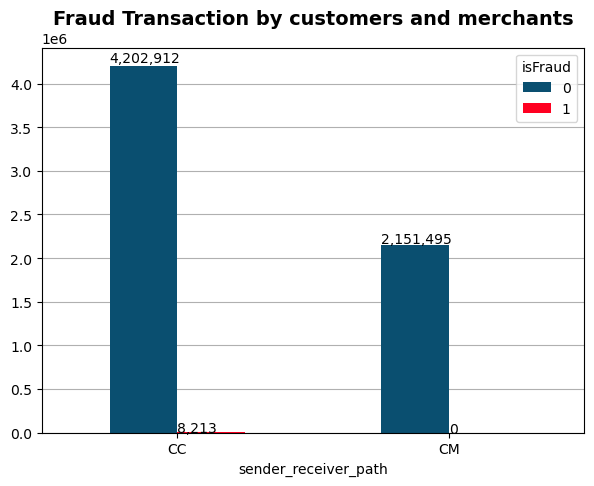

In [28]:
plot_bars_Fraud(pd.crosstab(index=data.sender_receiver_path,columns=data.isFraud),"Fraud Transaction by customers and merchants")

* As seen above, all the transactions with the merchant only in the receiver name are in payment type.
* All fraudulent transactions were made by customers.

In [29]:
data[(data['type']=='TRANSFER') & (data['isFraud'] == 1)]['amount'].mean()

1480891.6729338542

### amount:

In [30]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
data[data['isFraud']==1].amount.describe()

count       8213.00000
mean     1467967.29914
std      2404252.94724
min            0.00000
25%       127091.33000
50%       441423.44000
75%      1517771.48000
max     10000000.00000
Name: amount, dtype: float64

Why are there transactions with 0 amount? let's check:

In [31]:
data[data['amount']==0]['isFraud'].count()

16

We can notice that all of them were detected as fraudulent transactions. But they are only 16 transactions and we have 8213 fraudulent transactions in total

In [32]:
print(f"Minimum transaction amounts: {data.amount.min()}")
print(f"Maximum transaction amounts: {format(int(data.amount.max()), ',d')}")

Minimum transaction amounts: 0.0
Maximum transaction amounts: 92,445,516


In [33]:
print(f"Minimum fraudulent transaction amounts: {data[data['isFraud']==1].amount.min()}")
print(f"Maximum fraudulent transaction amounts: {format(int(data[data['isFraud']==1].amount.max()), ',d')}")

Minimum fraudulent transaction amounts: 0.0
Maximum fraudulent transaction amounts: 10,000,000


Text(0.5, 1.0, 'Amounts of fraudulent transactions')

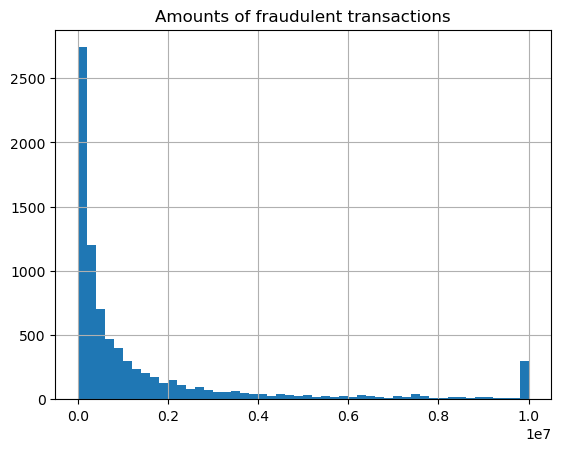

In [34]:
data[data['isFraud']==1]['amount'].hist(bins=50)
plt.title('Amounts of fraudulent transactions')

* It's clear to see that the feature amount is skewed left, and the most of the fraudulent transactions are with amounts between 0 - 1M.

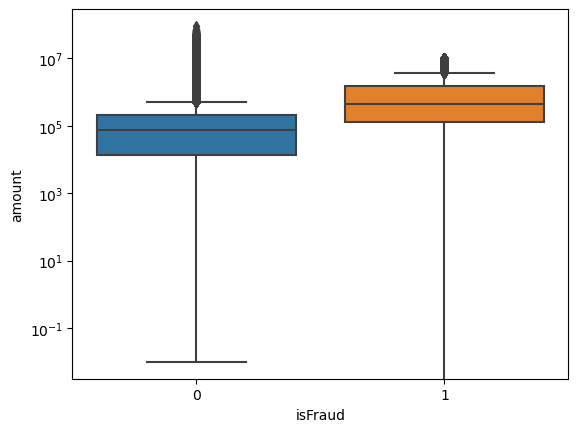

In [35]:
sns.boxplot(x = 'isFraud', y = 'amount', data = data).set_yscale('log')

In [36]:
print(f"the average of fraudulent transactions amounts: {format(int(data[data['isFraud']==1]['amount'].mean()), ',d')}")
print(f"the average of non-fraudulent transactions amounts: {format(int(data[data['isFraud']==0]['amount'].mean()), ',d')}")

the average of fraudulent transactions amounts: 1,467,967
the average of non-fraudulent transactions amounts: 178,197


We can see that the average of fraudulent transactions amounts higher than the average of non-fraudulent transactions amounts.

In [37]:
Total_receivers = data.nameDest.nunique()
Total_receivers_Fraud = data[data['isFraud']==1].nameDest.nunique()
print(f"Total receivers: {Total_receivers}")
print(f"Total receivers with fraudulent transactions: {Total_receivers_Fraud}")
print(f"Percentage of receivers that have fraudulent transactions is: {round((Total_receivers_Fraud/Total_receivers)*100,2)}%")

Total receivers: 2722362
Total receivers with fraudulent transactions: 8169
Percentage of receivers that have fraudulent transactions is: 0.3%


Senders who appeared as receivers too:

In [38]:
receivers = data['nameDest'].drop_duplicates()
senders_appeared_as_receivers = data[data['nameOrig'].isin(receivers)]['nameOrig'].drop_duplicates()

In [39]:
data[data['nameOrig'].isin(senders_appeared_as_receivers)]['isFraud'].value_counts()

0    1771
Name: isFraud, dtype: int64

As seen above the senders that were receivers too, hadn't Fraudulent transactions.

Senders and receivers that have more than one transaction and have fraudulent transactions:

In [40]:
# Count of transactions for each sender/receiver:
nameOrig_count = data.nameOrig.value_counts()
nameDest_count = data.nameDest.value_counts()

# Stay with senders/receivers that have more than one transaction:
nameOrig_arr = nameOrig_count.loc[lambda x : x >1].index
nameDest_arr = nameDest_count.loc[lambda x : x >1].index

# Stay with senders/receivers that have fraudulent transactions:
Senders_check=nameOrig_arr.isin(data.nameOrig[data.isFraud==1].values)
Senders_with_multiple_transaction = nameOrig_arr[Senders_check]

Receivers_check=nameDest_arr.isin(data.nameDest[data.isFraud==1].values)
Receivers_with_multiple_transaction = nameDest_arr[Receivers_check]

print(f"There are {Senders_with_multiple_transaction.nunique()} senders that have more than one transaction that include fraudulent transactions")
print(f"There are {Receivers_with_multiple_transaction.nunique()} receivers that have more than one transaction that include fraudulent transactions")

There are 28 senders that have more than one transaction that include fraudulent transactions
There are 5496 receivers that have more than one transaction that include fraudulent transactions


## Feature Engineering & Data Cleaning:

### New Features:

Adding new features based on the data:

Amount range:

In [41]:
cond = [((data.amount >= 0) & (data.amount <= 10000)) ,
    ((data.amount > 10000) & (data.amount <= 20000)),
    ((data.amount > 20000) & (data.amount <= 30000)),
    ((data.amount > 30000) & (data.amount <= 400000)),
    ((data.amount > 40000) & (data.amount <= 50000)),
    ((data.amount > 50000) & (data.amount <= 60000)),
    ((data.amount > 60000) & (data.amount <= 70000)),
    ((data.amount > 70000) & (data.amount <= 80000)),
    ((data.amount > 80000) & (data.amount <= 90000)),
    ((data.amount > 90000))]
values = [1,2,3,4,5,6,7,8,9,10]
data['amount_range'] = np.select(cond, values)

The average of transactions amount for each customer:

In [42]:
data = data.join(
    data.groupby('nameDest')[['amount']]
        .transform('mean')  # Calculate the average of transactions for each customer
,  rsuffix='_mean_nameDest')

In [43]:
data = data.join(
    data.groupby('nameOrig')[['amount']]
        .transform('mean')  # Calculate the average of transactions for each customer
,  rsuffix='_mean_nameOrig')

In [44]:
cond = [((data.amount_mean_nameDest >= 0) & (data.amount_mean_nameDest <= 500000)) ,
    ((data.amount_mean_nameDest > 500000) & (data.amount_mean_nameDest <= 1000000)),
    ((data.amount_mean_nameDest > 1000000))]
values = [1,2,3]
data['amount_mean_range_Destination'] = np.select(cond, values)

In [45]:
cond = [((data.amount_mean_nameOrig >= 0) & (data.amount_mean_nameOrig <= 500000)) ,
    ((data.amount_mean_nameOrig > 500000) & (data.amount_mean_nameOrig <= 1000000)),
    ((data.amount_mean_nameOrig > 1000000))]
values = [1,2,3]
data['amount_mean_range_Origin'] = np.select(cond, values)

Number of transactions for each customer:

In [46]:
data = data.join(
    data.groupby('nameDest')[['amount']]
        .transform('count')  # Calculate the transactions number for each customer
,  rsuffix='_count_nameDest')

In [47]:
data = data.join(
    data.groupby('nameOrig')[['amount']]
        .transform('count')  # Calculate the transactions number for each customer
,  rsuffix='_count_nameOrig')

Transactions number range:

In [48]:
cond = [(data.amount_count_nameDest == 1),
    ((data.amount_count_nameDest > 1) & (data.amount_count_nameDest <= 10)) ,
    ((data.amount_count_nameDest > 10) & (data.amount_count_nameDest <= 20)),
    (data.amount_count_nameDest > 20)]
values = [1,2,3,4]
data['transaction_count_range_nameDest'] = np.select(cond, values)

In [49]:
cond = [(data.amount_count_nameOrig == 1),
    (data.amount_count_nameOrig == 2),
    (data.amount_count_nameOrig == 3)]
values = [1,2,3]
data['transaction_count_range_nameOrig'] = np.select(cond, values)

The sum of all transactions for each customer:

In [50]:
data = data.join(
    data.groupby('nameDest')[['amount']]
        .transform('sum')  # Calculate the sum of all transactions for each customer
,  rsuffix='_sum_nameDest')

In [51]:
data = data.join(
    data.groupby('nameOrig')[['amount']]
        .transform('sum')  # Calculate the sum of all transactions for each customer
,  rsuffix='_sum_nameOrig')

Transaction amount percentage for each customer:

In [52]:
data['amount_percentage_nameDest'] = data['amount']/data['amount_sum_nameDest']
data['amount_percentage_nameOrig'] = data['amount']/data['amount_sum_nameOrig']

Day number of the transaction: (Assuming the data was generated from the beginning of the month)

In [53]:
data['day_number'] = (data['step']/24).round()
data['day_number'] = np.where(data['day_number'] == 0,1,data['day_number'])

Week number of the transaction: (Assuming the data was generated from the beginning of the month)

In [54]:
data['week_number'] = (data['step']/168).round()
data['week_number'] = np.where(data['week_number'] == 0,1,data['week_number'])

Difference between steps (time) of transactions for each customer

In [55]:
data = data.join(
    data.groupby('nameDest')[['step']]
        .transform('diff')  # Calculate the difference between steps (time) for each customer
,  rsuffix='_diff_nameDest')

In [56]:
data = data.join(
    data.groupby('nameOrig')[['step']]
        .transform('diff')  # Calculate the difference between steps (time) for each customer
,  rsuffix='_diff_nameOrig')

Difference between transactions amount for each customer:

In [57]:
data = data.join(
    data.groupby('nameDest')[['amount']]
        .transform('diff')  # Calculate the difference between transactions amount for each customer
,  rsuffix='_diff_nameDest')

In [58]:
data = data.join(
    data.groupby('nameOrig')[['amount']]
        .transform('diff')  # Calculate the difference between transactions amount for each customer
,  rsuffix='_diff_nameOrig')

Difference percentage of the transaction amounts:

In [59]:
data['amount_diff_percentage_nameDest'] = data['amount_diff_nameDest']/data['amount_sum_nameDest']
data['amount_diff_percentage_nameOrig'] = data['amount_diff_nameOrig']/data['amount_sum_nameOrig']

Serial number of each transaction:

In [60]:
data['nameDest_Rank'] = data.groupby('nameDest')['step'].rank(ascending=True).round()

#### Handeling Nulls:

In [61]:
data = data.fillna(0)

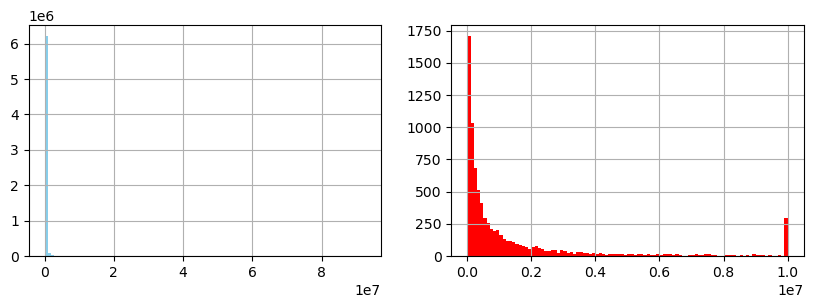

In [62]:
plot_NotFraud_vs_Fraud('amount')

It's clear to see that the feature amount is skewed left, and most of the fraud transactions are with amounts between 0 - 1M

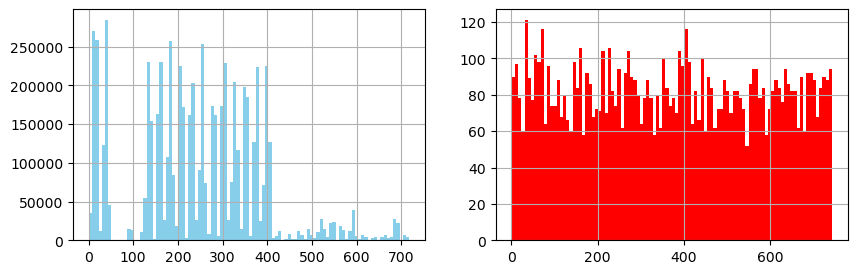

In [63]:
plot_NotFraud_vs_Fraud('step')

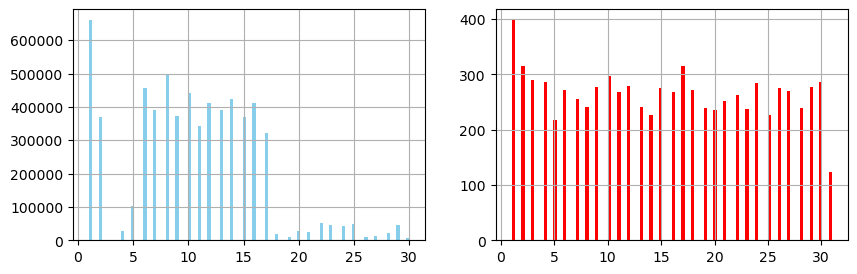

In [64]:
plot_NotFraud_vs_Fraud('day_number')

In [65]:
data[(data['isFraud']==1) & (data['type']== 'TRANSFER')]['amount'].value_counts().head(3)

10000000.00000    145
429257.45000        2
1165187.89000       2
Name: amount, dtype: int64

In [66]:
data[(data['isFraud']==0) & (data['type']== 'TRANSFER')]['amount'].value_counts().head(3)

10000000.00000    2920
198408.20000         3
443116.03000         3
Name: amount, dtype: int64

We can see that there are fraudulent transactions and non fraudulent transactions with amount=10,000,000 in transfer type. Therefore we can't conclude that if the amount of transfer transaction equal to 10,000,000 then it's a fraudulent transaction.

In [67]:
data[(data['isFraud']==1) & (data['type']== 'CASH_OUT')]['amount'].value_counts().head(3)

10000000.00000    142
0.00000            16
429257.45000        2
Name: amount, dtype: int64

In [68]:
data[(data['isFraud']==0) & (data['type']== 'CASH_OUT')]['amount'].value_counts().head(3)

120000.00000    29
70000.00000      5
10066.73000      4
Name: amount, dtype: int64

In type cash out only fraudulent transactions with amount=10,000,000. Then we can assume that every cash out transaction with amount=10,000,000 it's a fraudulent transactions.

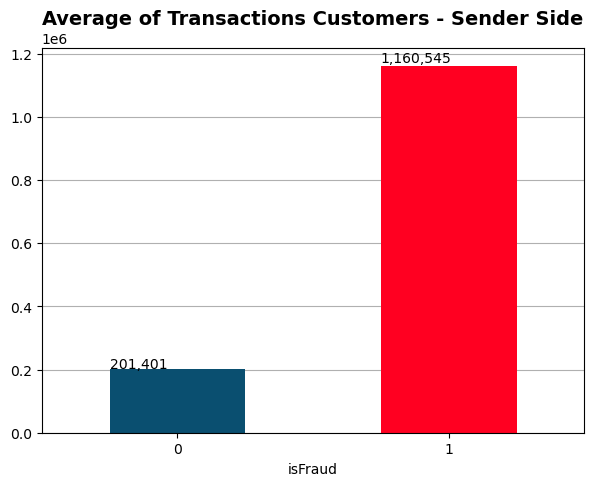

In [69]:
plot_bars_Fraud(data[['isFraud','amount_mean_nameOrig']].drop_duplicates().groupby('isFraud')['amount_mean_nameOrig'].mean(),
                "Average of Transactions Customers - Sender Side")

The average of transactions amounts of customers (sender side) who had fraudulent transactions is almost 1M. While the average of transactions amounts of customers who hadn’t had fraudulent transactions is almost 200K.

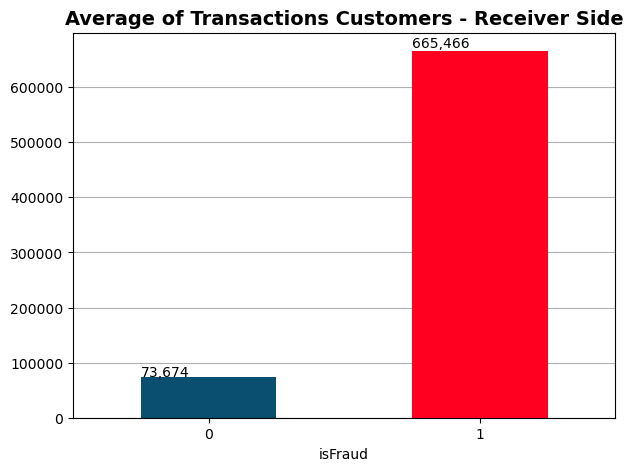

In [70]:
plot_bars_Fraud(data[['isFraud','amount_mean_nameDest']].drop_duplicates().groupby('isFraud')['amount_mean_nameDest'].mean(),
                "Average of Transactions Customers - Receiver Side")

The average of transactions amounts of customers (receiver side) who had fraudulent transactions is almost 665k. While the average of transactions amounts of customers who hadn’t had fraudulent transactions is almost 73K.

### Data Preparation for Modeling:

* According to the important note in the description of the dataset "NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used". So I'll drop these features.
* nameOrig & nameDest are ids for the senders and the receiver.
* "isFlaggedFruad" is affectless, therefore I decided to drop it.

In [71]:
data1 = data.drop(['nameOrig','oldbalanceOrg','newbalanceOrig','nameDest', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud'], axis=1)

Remove transactions with amount = 0:

In [72]:
data1 = data1[data1['amount'] != 0]

### One hot encoding for categorical features:

In [73]:
ohe_cols = ['type','amount_range', 'week_number','day_number','sender_receiver_path','transaction_count_range_nameDest',
            'transaction_count_range_nameOrig','amount_mean_range_Destination','amount_mean_range_Origin']
# create an encoder and fit the dataframe
ohe = OneHotEncoder(sparse_output=False).fit(data1[ohe_cols])

encoded = ohe.transform(data1[ohe_cols])
# convert it to a dataframe
encoded_df = pd.DataFrame(
     encoded,
     columns=ohe.get_feature_names_out())

data1 = pd.concat([data1[[x for x in data1.columns if x not in ohe_cols]].reset_index(drop=True),encoded_df], axis=1)

In [74]:
data1.shape

(6362604, 78)

#### Split for train and test:

In [ ]:
train, test =  train_test_split(data1, train_size=0.95, random_state=42, stratify=data1['isFraud'])

#### Removing outliers from train

In [ ]:
sigma_range = Sigma_Range()
train = sigma_range.fit_transform(train)

Splitting the data:

In [ ]:
X_train = train.drop(['isFraud'], axis=1)
X_test = test.drop(['isFraud'], axis=1)
y_train = train['isFraud'].astype(int)
y_test = test['isFraud'].astype(int)

#### Scaling:

In [ ]:
mms = MinMaxScaler()
X_train = pd.DataFrame( mms.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame( mms.transform(X_test), columns=X_train.columns)

#### Imbalanced data - Undersample

In [ ]:
undersample = RandomUnderSampler(random_state=42, sampling_strategy=0.1)


In [ ]:
X_train, y_train = undersample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

In [ ]:
plot_bars_Fraud(y_train.value_counts(),"isFraud Transactions")

# Models Selection

### Logistic Regression:

In [ ]:
lr = LogisticRegression(C=1000)
lr.fit(X_train,y_train)

In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, lr)

### MLPClassifier - neural network:

In [ ]:
RandomState = 100
ncols = len(X_train.columns)
hidden_layers = (ncols,ncols,ncols,ncols,ncols)
MLP = MLPClassifier(hidden_layer_sizes=hidden_layers,max_iter=1000,random_state=RandomState)
MLP = MLP.fit(X_train,y_train)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, MLP)

### RandomForestClassifier:

In [ ]:
parametersRF = {'n_estimators':10,'class_weight': "balanced_subsample",'n_jobs':-1,'random_state':42}
RF = RandomForestClassifier(**parametersRF)
RF = RF.fit(X_train, y_train)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, RF)

### Decision Tree Classifier:

In [ ]:
DT = DecisionTreeClassifier()
DT = DT.fit(X_train, y_train)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, DT)

### SVM:

In [ ]:
svm = SVC(kernel='rbf', gamma = 0.01, C=100, probability=True)
svm = svm.fit(X_train,y_train)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, svm)


### XGBClassifier:

In [ ]:
XGBC = XGBClassifier(
        objective= 'binary:logistic',
        max_depth = 15,
        min_child_weight = 1,
        gamma = 0,
        subsample = 1,
        colsample_bytree = 0.6,
        scale_pos_weight = 0.1,
        seed=35)
XGBC.fit(X_train, y_train)

model_results(X_train,y_train ,X_test, y_test, XGBC)

### KNeighborsClassifier:

In [ ]:
neigh = KNeighborsClassifier(n_neighbors = 15 )
neigh.fit(X_train,y_train)

In [ ]:
model_results(X_train,y_train ,X_test, y_test, neigh)

### LGBMClassifier:

In [ ]:
lgbm = LGBMClassifier(boosting_type = 'gbdt',objective = 'binary', random_state = 100)

lgbm.fit(X_train,y_train)

model_results(X_train,y_train ,X_test, y_test, lgbm)

#### Roc:

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax = fig.gca()
# plot "No-Skill" on ROC Curve
ax.plot([0,1],[0,1], linestyle='--', label='No Skill')
plot_roc_auc(ax, lr, X_test, y_test, label='Logistic Regression',coloroc='pink')
plot_roc_auc(ax, RF, X_test, y_test, label='Random Forest Classifier',coloroc='green')
plot_roc_auc(ax, XGBC, X_test, y_test, label='XGB Classifier',coloroc='red')
plot_roc_auc(ax, lgbm, X_test, y_test, label='LGBMClassifier',coloroc = "orange")
plot_roc_auc(ax, MLP, X_test, y_test, label='MLP Classifier - neural network',coloroc = "navy")
plot_roc_auc(ax, neigh, X_test, y_test, label='K Neighbors Classifier',coloroc = "black")
plt.show()